In [46]:
# Importing packages
from time import time
#from cupyx.time import repeat
import numpy as np
#import cupy as cp
from numba import njit, vectorize, guvectorize
import ruptures as rpt
from ruptures.metrics import precision_recall
from ruptures.metrics import hausdorff
from ruptures.metrics import randindex
#from pychange.gpu.costs import normal_mean_var_cost as gpu_normal_mean_var_cost
#from pychange.gpu.preprocess import create_summary_stats as gpu_create_summary_stats
#from pychange.gpu.segment import pelt as gpu_pelt
from pychange.costs import normal_mean_var_cost, nonparametric_cost, ParametricCost, NonParametricCost
from pychange.segment import pelt
from pychange.preprocess import create_summary_stats, create_partial_sums
import matplotlib.pyplot as plt

# import rpy2's package module
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects

# import R's utility package
utils = rpackages.importr('utils')
rcp = rpackages.importr('changepoint')
rcpnp = rpackages.importr('changepoint.np')

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
# Creating test data with random normal
#n_total = np.logspace(1.5, 3.5, num=5)
def make_test_series(series_length=200, n_series=12):
    
    _x = np.hstack([np.random.normal(np.random.uniform(0, 20, size=(1,))[0],
                                       np.random.uniform(1e-2, 20, size=(1,))[0],
                                       (series_length,)) for _ in range(n_series)])
    true = [i * series_length for i in range(1, n_series + 1)]
    
    return _x, true
test_series, true_series = make_test_series(200, 10)
test_series = test_series.astype(np.float32)
r_series = robjects.FloatVector(np.array(test_series))

In [5]:
# Storing results
results = {'r': [], 'ruptures': [], 'pychange': []}

In [6]:
# Setting hyperparameters
k = 20
pen = 100
np_model = NonParametricCost(nonparametric_cost, k)
model = ParametricCost(normal_mean_var_cost)
#rup_model = NonParametricCost(aot_nonparametric_cost, k)

In [7]:
model = ParametricCost(normal_mean_var_cost)
sumstats = create_summary_stats(test_series)
inds= np.arange(0, test_series.shape[0])

In [8]:
# Pychange
results['pychange'] = pelt(test_series, 30, 100, model)
results['pychange'] = [i for i in results['pychange'] if i != 0]
results['pychange'].append(test_series.shape[0])

In [9]:
# R changepoint benchmark
results['r'] = np.array(rcp.cpts(rcp.cpt_meanvar(r_series, penalty="Manual", pen_value=100, method='PELT', test_stat='Normal')))
results['r'] = list(results['r'])
results['r'].append(test_series.shape[0])

In [10]:
# R changepoint benchmark
results['r'] = np.array(rcp.cpts(rcpnp.cpt_np(r_series, penalty="Manual", pen_value=100, method='PELT', nquantiles=20)))
results['r'] = list(results['r'])
results['r'].append(test_series.shape[0])

In [11]:
%lprun -f pelt pelt(test_series, 30, pen, model)

In [12]:
for i in np.linspace(1000, 5000, num=10, dtype=np.int32):
    
    test_series, _ = make_test_series(i, 5)
    r_series = robjects.FloatVector(np.array(test_series))
    
    start_time = time()
    _ = pelt(test_series, 30, pen, np_model)
    pychange_time = round(time() - start_time, 3)
    
    start_time = time()
    #_ = np.array(rcp.cpts(rcpnp.cpt_np(r_series, penalty="Manual", pen_value=pen, method='PELT', nquantiles=k)))
    _ = rcpnp.cpt_np(r_series, penalty="Manual", pen_value=pen, method='PELT', nquantiles=k)
    r_time = round(time() - start_time, 3)
    print(f'NP | Size: {i} | Pychange: {pychange_time} | R: {r_time} | {round(r_time / pychange_time, 2)}x speed')
    
    start_time = time()
    _ = pelt(test_series, 30, pen, model)
    pychange_time = round(time() - start_time, 3)
    
    start_time = time()
    #_ = np.array(rcp.cpts(rcpnp.cpt_np(r_series, penalty="Manual", pen_value=pen, method='PELT', nquantiles=k)))
    _ = rcp.cpt_meanvar(r_series, penalty="Manual", pen_value=pen, method='PELT', test_stat='Normal')
    r_time = round(time() - start_time, 3)
    print(f'Para | Size: {i} | Pychange: {pychange_time} | R: {r_time} | {round(r_time / pychange_time, 2)}x speed')

NP | Size: 1000 | Pychange: 0.296 | R: 4.406 | 14.89x speed
Para | Size: 1000 | Pychange: 0.575 | R: 0.29 | 0.5x speed
NP | Size: 1444 | Pychange: 0.484 | R: 8.153 | 16.85x speed
Para | Size: 1444 | Pychange: 1.105 | R: 0.245 | 0.22x speed


KeyboardInterrupt: 

In [56]:
del normal_mean_var_cost

In [71]:
#@njit(fastmath=True)
def normal_mean_var_cost(x):
    #_x = x[end, :] - x[start, :]
    _x = x
    _pi_const = np.log(2 * np.pi)
    return _x[:, 3] * (_pi_const + np.log(np.fmax((_x[:, 1] - ((_x[:, 0] * _x[:, 0]) / _x[:, 3]))/ _x[:, 3], 1e-8) + 1))

In [74]:
%lprun -f normal_mean_var_cost  normal_mean_var_cost(sum_stats)

<ipython-input-71-9ca75775d1cb>:6: RuntimeWarning: invalid value encountered in true_divide
  return _x[:, 3] * (_pi_const + np.log(np.fmax((_x[:, 1] - ((_x[:, 0] * _x[:, 0]) / _x[:, 3]))/ _x[:, 3], 1e-8) + 1))


In [45]:
sum_stats = create_summary_stats(test_series).astype('float32')
costs = np.zeros((sum_stats.shape[0],))

In [43]:
vec_normal_mean_var_cost(sum_stats)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(float32, Literal[int](1))
 
There are 22 candidate implementations:
[1m      - Of which 22 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(float32, int64)':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of intrinsic-call at <ipython-input-41-a42fa6b17f8d> (6)[0m
[0m[1mDuring: typing of static-get-item at <ipython-input-41-a42fa6b17f8d> (6)[0m
[1m
File "<ipython-input-41-a42fa6b17f8d>", line 6:[0m
[1mdef vec_normal_mean_var_cost(x):
    <source elided>
    _pi_const = np.log(2 * np.pi)
[1m    _a = np.fmax((x[1] - ((x[0] * x[0]) / x[3]))/ x[3])
[0m    [1m^[0m[0m


In [ ]:
# Ruptures
results['ruptures'] = rpt.Pelt(custom_cost=ParametricCost(cost_fn=aot_scalar_normal_mean_var_cost)).fit(test_series).predict(pen=100)

In [13]:
# Ruptures
results['ruptures'] = rpt.Pelt(custom_cost=rup_model).fit(test_series).predict(pen=100)

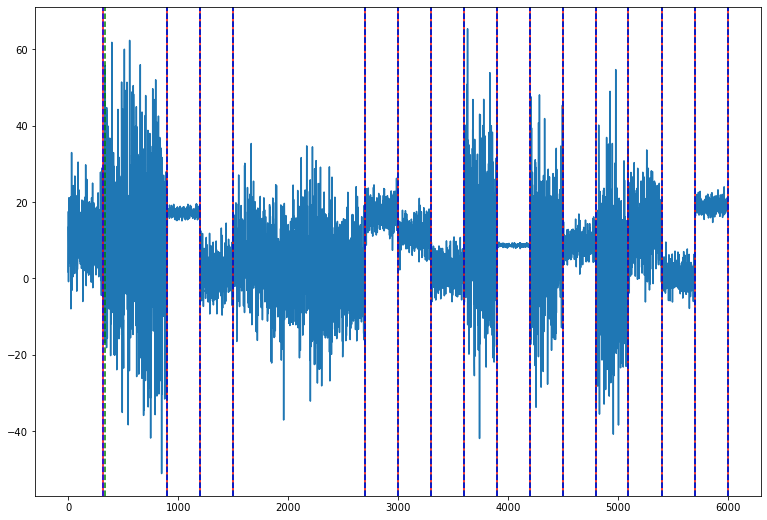

In [14]:
plt.figure(figsize=(13, 9))
plt.plot(test_series)
for i in results['r']:
    plt.axvline(i, color='red')
for i in results['ruptures']:
    plt.axvline(i, color='green', linestyle='--')
for i in results['pychange']:
    plt.axvline(i, color='blue', linestyle='--')
plt.show()

In [15]:
print('Precision')
print('R:', precision_recall(true_series, results['r']))
print('Pychange:', precision_recall(true_series, results['pychange']))
print('Ruptures:', precision_recall(true_series, results['ruptures']))

Precision
R: (0.9333333333333333, 0.7368421052631579)
Pychange: (0.9333333333333333, 0.7368421052631579)
Ruptures: (0.9333333333333333, 0.7368421052631579)


In [16]:
print('Hausdorff')
print('R:', hausdorff(true_series, results['r']))
print('Pychange:', hausdorff(true_series, results['pychange']))
print('Ruptures:', hausdorff(true_series, results['ruptures']))

Hausdorff
R: 600.0
Pychange: 600.0
Ruptures: 600.0


In [17]:
print('Rand Index')
print('R:', randindex(true_series, results['r']))
print('Pychange:', randindex(true_series, results['pychange']))
print('Ruptures:', randindex(true_series, results['ruptures']))
print('R & Ruptures:', randindex(results['r'], results['ruptures']))
print('R & Pychange:', randindex(results['r'], results['pychange']))
# https://arxiv.org/abs/2003.06222

Rand Index
R: 0.9640750555555555
Pychange: 0.9640750555555555
Ruptures: 0.9643847222222223
R & Ruptures: 0.9989914444444444
R & Pychange: 1.0
